In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import kaggle
import warnings

plt.style.use('ggplot')
kaggle.api.authenticate()
warnings.filterwarnings('ignore')

In [2]:
#kaggle.api.dataset_download_files('mirichoi0218/insurance',path='csv_files',unzip=True)

In [3]:
df=pd.read_csv('csv_files/insurance.csv')

In [4]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


##### ANOVA

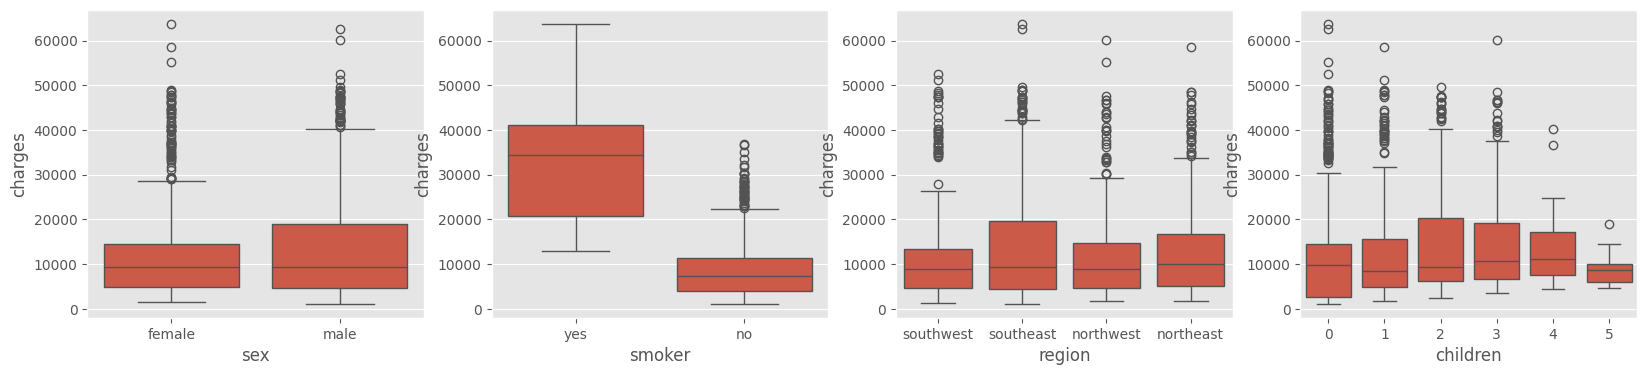

In [5]:
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(20,4))

sns.boxplot(df,x='sex',y='charges',ax=ax1)
sns.boxplot(df,x='smoker',y='charges',ax=ax2)
sns.boxplot(df,x='region',y='charges',ax=ax3)
sns.boxplot(df,x='children',y='charges',ax=ax4)

plt.show()

In [6]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('charges ~ sex + smoker + region + children', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

p_values = anova_table['PR(>F)']

# Set significance level
significance_level = 0.01  # 99% confidence level

# Print significant columns
print("Significant columns with 99% confidence:")
for column, p_value in zip(p_values.index[1:], p_values[1:]):
    if p_value < significance_level:
        print(column)


Significant columns with 99% confidence:
smoker
children


In [7]:
df=df.drop(columns=['sex','region'])

##### Continues variables

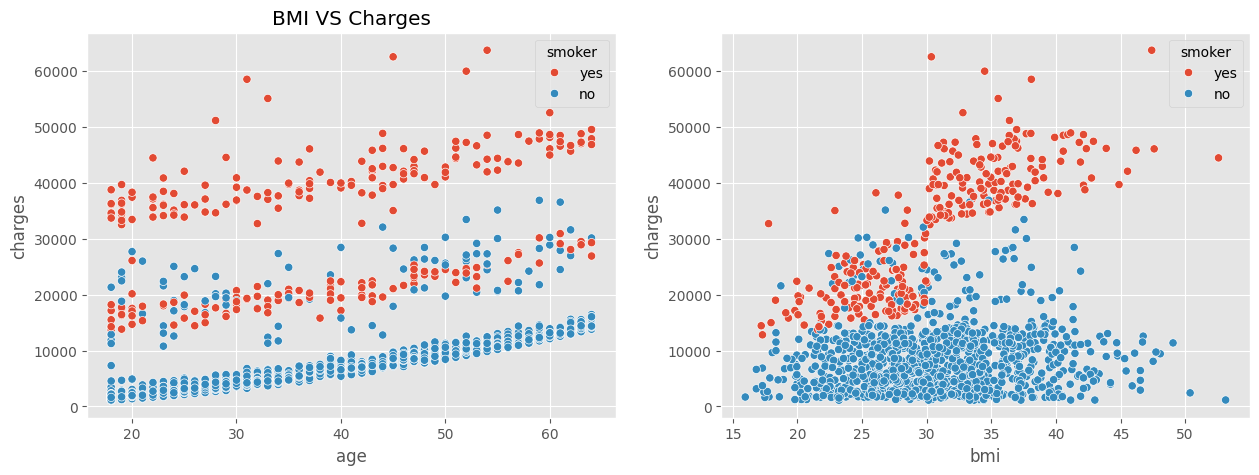

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

sns.scatterplot(df,x='age',y='charges',hue='smoker',ax=ax1)
ax1.set_title('Age VS Charges')
sns.scatterplot(df,x='bmi',y='charges',hue='smoker',ax=ax2)
ax1.set_title('BMI VS Charges')

plt.show()

In [9]:
for col in df.select_dtypes([object]).columns:
    dummies=pd.get_dummies(df[col],prefix=col,dummy_na=False)
    df=df.drop(columns=col)
    df=pd.concat([df,dummies],axis=1)

### Building ML Model

In [10]:
X=df.drop(columns='charges')
y=df['charges']

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [11]:
from xgboost import XGBRegressor
model=XGBRegressor()

In [12]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model):
    train_sizes,train_scores,test_scores=learning_curve(
        X=X_train,
        y=y_train,
        estimator=model,
        train_sizes=np.linspace(0.1,1,10),
        cv=3,
        scoring='neg_root_mean_squared_error',
        verbose=1
    )
    
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy', color='red')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='red')
    plt.xlabel('Training Set Size')
    plt.ylabel('MAE')
    plt.title('Learning Curve for XGBoost Regressor')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

[learning_curve] Training set sizes: [ 71 142 213 285 356 427 499 570 641 713]


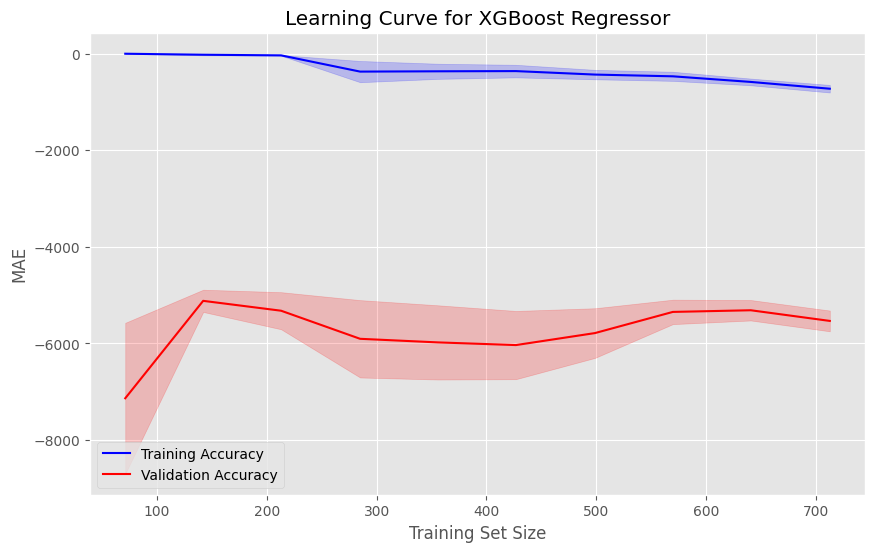

In [13]:
plot_learning_curve(XGBRegressor()) #initial model

%%time

from sklearn.model_selection import GridSearchCV

param_grid={'n_estimators':[100,500,1000,2000],
            'max_depth':[3,5,8,10],
            'learning_rate':[0.01,0.05,0.1,0.15]}

grid_search_cv=GridSearchCV(estimator=XGBRegressor(),
                         param_grid=param_grid,
                         scoring='neg_root_mean_squared_error',
                         cv=3,
                         verbose=10)

grid_search_cv.fit(X_train,y_train)

best_model=grid_search_cv.best_estimator_
print(grid_search_cv.best_estimator_)
print(grid_search_cv.best_score_)
print(grid_search_cv.best_params_)

In [14]:
import joblib
#joblib.dump(best_model,'best_model.pickle')
best_model=joblib.load('best_model.pickle')


[learning_curve] Training set sizes: [ 71 142 213 285 356 427 499 570 641 713]


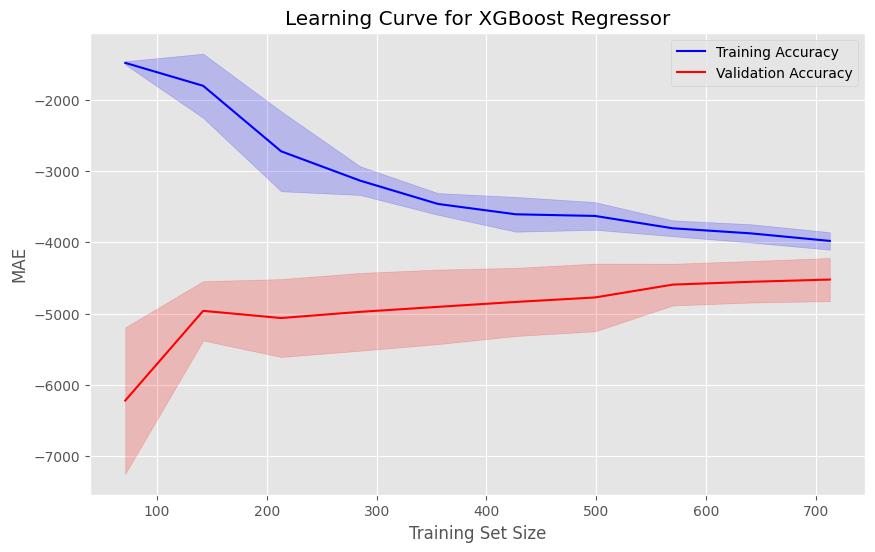

In [15]:
plot_learning_curve(best_model)

In [16]:
train_prediction=best_model.predict(X_train)
test_prediction=best_model.predict(X_test)

In [17]:
from sklearn import metrics

r2_train=metrics.r2_score(train_prediction,y_train)
r2_test=metrics.r2_score(test_prediction,y_test)
mae_train=metrics.mean_absolute_error(train_prediction,y_train)
mae_test=metrics.mean_absolute_error(test_prediction,y_test)
rmse_train=metrics.mean_squared_error(train_prediction,y_train,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,y_test,squared=False)
train_scores={'R2_train':r2_train,'MAE_train':mae_train,'RMSE_train':rmse_train}
test_scores={'R2_test':r2_test,'MAE_test':mae_test,'RMSE_test':rmse_test}
print(train_scores)
print(test_scores)

{'R2_train': 0.8579588484145104, 'MAE_train': 2308.1158134586885, 'RMSE_train': 4169.377982436709}
{'R2_test': 0.8409477259561634, 'MAE_test': 2455.848439753381, 'RMSE_test': 4459.623306372217}


### Error Analysis

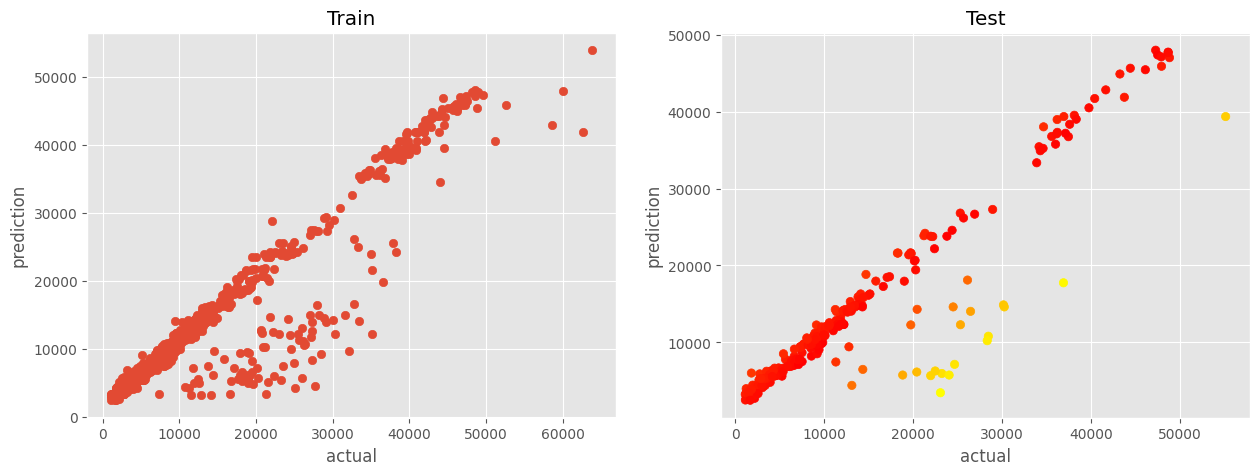

In [18]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(y_train,train_prediction)
ax1.set_xlabel('actual')
ax1.set_ylabel('prediction')
ax1.set_title('Train')
ax2.scatter(y_test,test_prediction,c=(y_test-test_prediction).abs(),cmap='autumn')
ax2.set_xlabel('actual')
ax2.set_ylabel('prediction')
ax2.set_title('Test')
    
plt.show()

In [19]:
X_test['Prediction']=test_prediction
X_test['Actual']=y_test
X_test['ABS Error']=(y_test-test_prediction).abs()

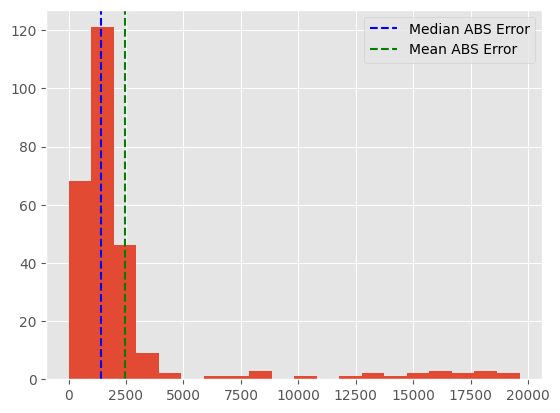

In [20]:
X_test['ABS Error'].hist(bins=20)
plt.axvline(X_test['ABS Error'].median(),color='blue',label='Median ABS Error',ls='--')
plt.axvline(X_test['ABS Error'].mean(),color='green',label='Mean ABS Error',ls='--')

plt.legend()
plt.show()

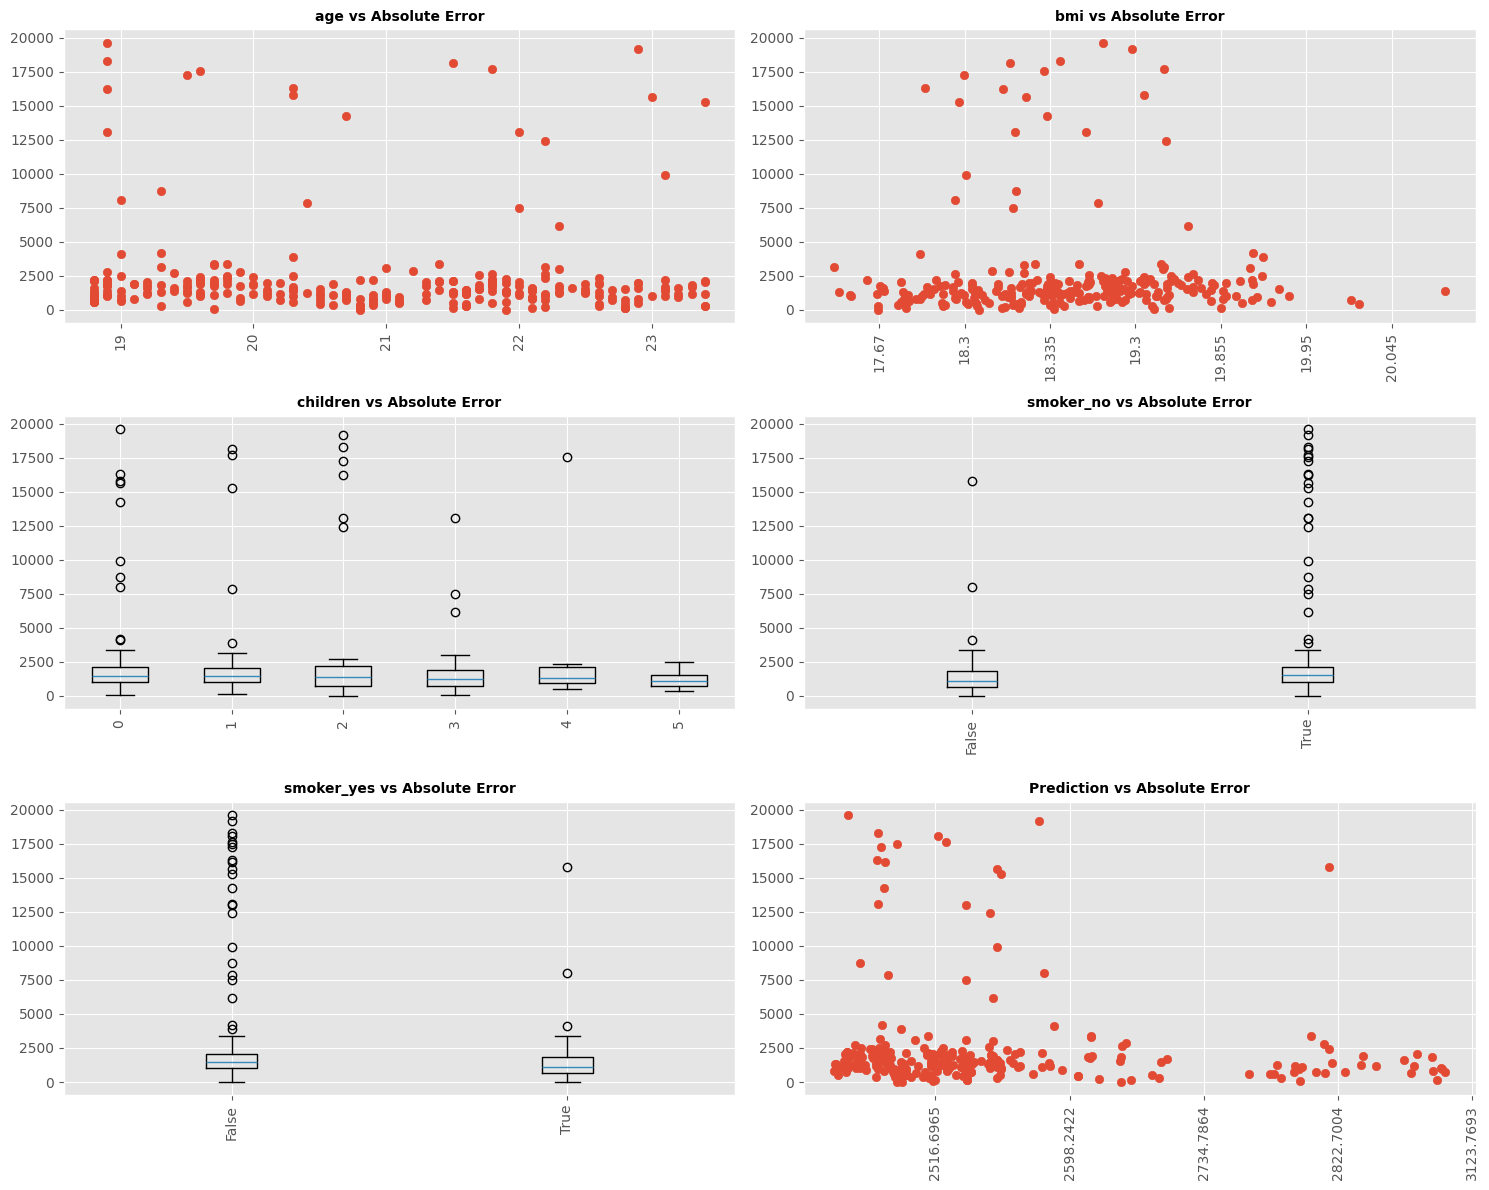

In [21]:
fig,axes=plt.subplots(3,2,figsize=(15,12))

for col,ax in zip(X_test.columns,axes.ravel()):
    X_test=X_test.sort_values(col)
    if X_test[col].nunique()<=25:
        ax.boxplot(labels=X_test[col].unique(),
                   x=[X_test[X_test[col]==label]['ABS Error'] for label in X_test[col].unique()])
        ax.set_title(f'{col} vs Absolute Error',fontweight='bold',size=10)
        ax.set_xticklabels(X_test[col].unique(),rotation=90)
    else:
        ax.scatter(x=X_test[col],y=X_test['ABS Error'])
        ax.set_title(f'{col} vs Absolute Error',fontweight='bold',size=10)
        ax.set_xticklabels(X_test[col].unique(),rotation=90)
        #ax.set_xscale('log')
        #ax.set_yscale('log')

#plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()